In [1]:
from annoy import AnnoyIndex

In [2]:
import sqlite3
import random
import itertools
import subprocess
import os
import shlex
import time
import pickle
import joblib
from multiprocessing import Pool

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [5]:
from imageio import imread

In [6]:
from skimage.transform import resize
from sklearn.decomposition import PCA, IncrementalPCA

In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [8]:
print(tf.__version__)

1.14.0


In [9]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from tensorflow.keras.models import Model

# for tf 2
# from keras.applications.imagenet_utils import decode_predictions, preprocess_input

In [10]:
# this seems to help with some GPU memory issues

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#### Set hyperparameters

In [11]:
# mode = "vgg"
mode = "raw"
# mode = "dc"

In [12]:
# ann_filename = "test_5k_pca.ann"
# ann_filename = "120k_ipca.ann"
# ann_filename = "2k_pca.ann"
# ann_filename = "2k_ipca.ann"
# ann_filename = "2k_raw.ann"
# ann_filename = "2k_vgg_ipca.ann"
# ann_filename = "120k_vgg_ipca.ann"
# ann_filename = "600k_vgg_ipca.ann"
ann_filename = "600k_raw.ann"

In [13]:
# dataset_size = 2000 # testing
# dataset_size = 120000
dataset_size = 600000 # for saving IPCA files from 5% of data
batch_size = 2000
num_images = dataset_size

#### load image filepaths

In [14]:
# image_list = "/home/rte/data/paths/all_converted_jpg_images_shuf.txt"
# image_list = "/home/rte/data/paths/all_images_ordered.txt"
image_list = "/home/rte/data/paths/all_images_shuf.txt"

# image_folder = "/home/rte/data/images/web/120k/"
image_folder = "/mnt/hd2/images/all/"

In [15]:
filepaths = []

with open(image_list, "r") as f:
    lines = f.readlines()
    print("length:",len(lines))
    print(lines[0])
for l in lines:
    # substrings = l.rsplit(",", 1)
    filepaths.append(l.strip())
    # image_ids.append(substrings[1].strip())

length: 12694664
4111723.jpg



In [16]:
# get the image paths for all images that we have features for
images = []

for i, f in enumerate(filepaths[:]):
    images.append(image_folder + f)
print(len(images))
print(images[:10])

12694664
['/mnt/hd2/images/all/4111723.jpg', '/mnt/hd2/images/all/8551267.jpg', '/mnt/hd2/images/all/11614912.jpg', '/mnt/hd2/images/all/7374806.jpg', '/mnt/hd2/images/all/11647173.jpg', '/mnt/hd2/images/all/3806900.jpg', '/mnt/hd2/images/all/6229183.jpg', '/mnt/hd2/images/all/10482597.jpg', '/mnt/hd2/images/all/5670666.jpg', '/mnt/hd2/images/all/10022332.jpg']


In [17]:
# resize to make sure we don't try and read more images than we have
filepaths = filepaths[:dataset_size]
print(len(filepaths))

600000


In [18]:
X = [] # images as arrays
dim = 256 # size of one dimension
f = dim * dim # size of vector
num_workers = 8

In [19]:
def load_img(path, dim):
    im = Image.open(path).convert('RGB')
    img_x, img_y = im.size

    # im.show()

    if False:
        x_bigger = True if img_x > img_y else False
        ratio = img_x / img_y

        if x_bigger:
            factor = float(dim) / img_y 
        else:
            factor = float(dim) / img_x
        new_x = int(img_x * factor)
        new_y = int(img_y * factor)

        resized = im.resize((new_x, new_y), Image.ANTIALIAS)
        # resized.show()

        left = (new_x - dim)/2
        top = (new_y - dim)/2
        right = (new_x + dim)/2
        bottom = (new_y + dim)/2

        cropped = resized.crop((left, top, right, bottom))
#         cropped.show()

#     print("factor", factor)
#     print("ratio", ratio)
#     print(x_bigger)
#     print("img_x", img_x)
#     print("img_y", img_y)
#     print(new_x, new_y)
#     print("cropped", cropped.size)

    if True:
        # just resize to fill the box
        just_resize = im.resize((dim, dim), Image.ANTIALIAS)
    #     just_resize.show()
        return just_resize

    if False:
        if x_bigger:
            factor = float(dim) / img_x
        else:
            factor = float(dim) / img_y
        new_x = int(img_x * factor)
        new_y = int(img_y * factor)
    #     print("factor", factor)
    #     print("img_x", img_x)
    #     print("img_y", img_y)
        crop_resized = im.resize((new_x, new_y), Image.ANTIALIAS)

        # pad
        padded = Image.new("RGB", (dim, dim))
        padded.paste(crop_resized, ((dim - new_x)//2, (dim - new_y)//2))
        padded.show()
    
#     return just_resize
    return cropped

In [20]:
def image_worker(filename):
    img_data = np.array(load_img(filename, dim))# - mean
    return img_data

def image_worker_flat(filename):
    img_data = np.array(load_img(filename, dim)).flatten()# - mean
    return img_data

def image_worker_vgg(filename):
    img, x = load_image(filename);
    return x

In [21]:
mean = np.array([224.03429894, 223.6761458, 223.62304944]) # mean for 120k

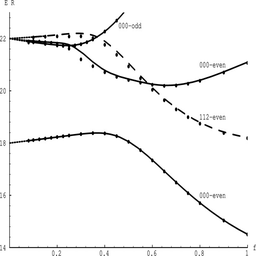

In [22]:
load_img(images[8], dim)

### Load images

Whole dataset

In [23]:
def load_all_data():
    image_batch = images[:num_images]
    overall_start = time.time()
    with Pool(num_workers) as p:
        X = p.map(image_worker_flat, image_batch)
    print(f"loaded {len(X)} images | time taken: {time.time() - overall_start}")
    return X

In [24]:
# X = load_all_data()

### Prepare feature extractor

In [25]:
if mode == "vgg":
    model = keras.applications.VGG16(weights='imagenet', include_top=True)
    model.summary()

In [26]:
if mode == "vgg":
    def load_image(path):
        img = image.load_img(path, target_size=model.input_shape[1:3])
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x

In [27]:
if mode == "vgg":
    img, x = load_image(images[8])
    print("shape of x: ", x.shape)
    print("data type: ", x.dtype)
    plt.imshow(img)

NameError: name 'load_image' is not defined

In [28]:
if mode == "vgg":
    predictions = model.predict(x)

    for _, pred, prob in decode_predictions(predictions)[0]:
        print("predicted %s with probability %0.3f" % (pred, prob))

NameError: name 'model' is not defined

In [29]:
if mode == "vgg":
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    # feat_extractor.summary()

NameError: name 'model' is not defined

## Dimensionality Reduction

In [30]:
n_components = 300

### IncrementalPCA

In [31]:
ipca = IncrementalPCA(n_components=n_components, batch_size=16)

#### feed ipca in batches


In [32]:
# old_batch_size = batch_size
# batch_size = 500
assert dataset_size % batch_size == 0, "dataset_size not a multiple of batch_size"
divisions = [x for x in range(0, dataset_size, batch_size)]
print("divisions:",divisions)
overall_start = time.time()

for div in divisions:
    X = []
#     print("batch:",div,div+batch_size)
#     for i, image in enumerate(images[div:div+batch_size]):
#         img_data = np.array(load_img(images[i], dim)) - mean
#         X.append(img_data.flatten())
    
    if mode == "vgg":
        print("loading images for VGG")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_vgg, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    

        # extract features
        features = []
        for x in X:
            feat = feat_extractor.predict(x)[0]
            features.append(feat)
        print(f"extracted features of {len(X)} images, time taken: {time.time() - start}")
        X = features
    else:
        print("loading images for raw processing")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_flat, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    
        
    print(X[0])
    print("size of data", len(X))
    start = time.time()
    ipca.partial_fit(X)
    print(f"partial fit time taken: {time.time() - start}")
print(f"total time taken: {time.time() - overall_start}")
# batch_size = old_batch_size

divisions: [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000

partial fit time taken: 156.45268964767456
loading images for raw processing
batch(64000, 66000) - time to load images: 87.859934091568
[144 144 144 ... 116 116 116]
size of data 2000
partial fit time taken: 157.17115712165833
loading images for raw processing
batch(66000, 68000) - time to load images: 85.78595352172852
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 156.24216747283936
loading images for raw processing
batch(68000, 70000) - time to load images: 86.3442702293396
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 155.8035638332367
loading images for raw processing
batch(70000, 72000) - time to load images: 88.5991268157959
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 156.0935778617859
loading images for raw processing
batch(72000, 74000) - time to load images: 87.840092420578
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 167.61152052879333
loading images for raw processing
b

partial fit time taken: 159.16228699684143
loading images for raw processing
batch(152000, 154000) - time to load images: 74.24796104431152
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 159.46157121658325
loading images for raw processing
batch(154000, 156000) - time to load images: 73.46793246269226
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 158.8755509853363
loading images for raw processing
batch(156000, 158000) - time to load images: 73.06684398651123
[139 139 139 ... 254 254 254]
size of data 2000
partial fit time taken: 159.33045530319214
loading images for raw processing
batch(158000, 160000) - time to load images: 76.96835851669312
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 158.1084475517273
loading images for raw processing
batch(160000, 162000) - time to load images: 75.37155222892761
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 159.14815664291382
loading images for 

partial fit time taken: 164.33322620391846
loading images for raw processing
batch(240000, 242000) - time to load images: 84.87549257278442
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 162.15023016929626
loading images for raw processing
batch(242000, 244000) - time to load images: 83.51603627204895
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 165.58328294754028
loading images for raw processing
batch(244000, 246000) - time to load images: 87.79821276664734
[254 254 254 ... 255 255 255]
size of data 2000
partial fit time taken: 165.2775547504425
loading images for raw processing
batch(246000, 248000) - time to load images: 86.72869443893433
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 161.13387513160706
loading images for raw processing
batch(248000, 250000) - time to load images: 84.9356951713562
[153 173 162 ... 135 159 161]
size of data 2000
partial fit time taken: 161.93322563171387
loading images for 

partial fit time taken: 166.74223852157593
loading images for raw processing
batch(328000, 330000) - time to load images: 63.051565408706665
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 168.79592943191528
loading images for raw processing
batch(330000, 332000) - time to load images: 62.41866183280945
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 169.99831676483154
loading images for raw processing
batch(332000, 334000) - time to load images: 64.26068305969238
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 165.92289805412292
loading images for raw processing
batch(334000, 336000) - time to load images: 61.538283348083496
[255 255 255 ... 253 253 253]
size of data 2000
partial fit time taken: 168.79479503631592
loading images for raw processing
batch(336000, 338000) - time to load images: 62.47561717033386
[121 121 121 ... 234 234 234]
size of data 2000
partial fit time taken: 169.41040182113647
loading images 

partial fit time taken: 167.63107895851135
loading images for raw processing
batch(416000, 418000) - time to load images: 64.83666038513184
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 167.38389897346497
loading images for raw processing
batch(418000, 420000) - time to load images: 56.40969395637512
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 191.51126313209534
loading images for raw processing
batch(420000, 422000) - time to load images: 66.36052179336548
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 166.5312511920929
loading images for raw processing
batch(422000, 424000) - time to load images: 61.92553949356079
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 174.6029930114746
loading images for raw processing
batch(424000, 426000) - time to load images: 63.95848298072815
[192 193 193 ... 255 255 255]
size of data 2000
partial fit time taken: 165.30815815925598
loading images for 

partial fit time taken: 165.44501852989197
loading images for raw processing
batch(504000, 506000) - time to load images: 68.32790899276733
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 162.48442029953003
loading images for raw processing
batch(506000, 508000) - time to load images: 55.117669343948364
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 184.98982620239258
loading images for raw processing
batch(508000, 510000) - time to load images: 72.00472021102905
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 164.31017136573792
loading images for raw processing
batch(510000, 512000) - time to load images: 76.42536568641663
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 165.37448072433472
loading images for raw processing
batch(512000, 514000) - time to load images: 71.0565083026886
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 165.7437708377838
loading images for

partial fit time taken: 164.822119474411
loading images for raw processing
batch(592000, 594000) - time to load images: 68.46346473693848
[31 33 32 ... 31 33 32]
size of data 2000
partial fit time taken: 163.93533086776733
loading images for raw processing
batch(594000, 596000) - time to load images: 71.90400528907776
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 164.7045385837555
loading images for raw processing
batch(596000, 598000) - time to load images: 69.15348625183105
[255 255 255 ...  26  26  26]
size of data 2000
partial fit time taken: 163.88724303245544
loading images for raw processing
batch(598000, 600000) - time to load images: 69.30799722671509
[255 255 255 ... 255 255 255]
size of data 2000
partial fit time taken: 165.6619095802307
total time taken: 72029.32045531273


In [33]:
# X_ipca = ipca.transform(X)

In [34]:
# joblib_path = "ipca_2k_test.joblib"
# joblib_path = "ipca_120k_test.joblib"
joblib_path = ann_filename.split(".")[0] + "_ipca.joblib"

In [35]:
print(joblib_path)

600k_raw_ipca.joblib


In [36]:
with open(joblib_path, "wb") as f:
    joblib.dump(ipca, f)

In [37]:
# load ipca
# with open(joblib_path, "rb") as f:
#     load_ipca = joblib.load(f) 

In [38]:
print("n_samples_seen_:", ipca.n_samples_seen_)

n_samples_seen_: 600000


### Approximate Nearest Neighbours

In [39]:
# pca
t = AnnoyIndex(300, 'angular')  # Length of item vector that will be indexed

# raw
# t = AnnoyIndex(256*256*3, 'angular')  # Length of item vector that will be indexed

t.set_seed(10)

In [40]:
# feed annoy all in one go

# annoy_data = X_pca
# annoy_data = X_ipca
# # annoy_data = X
# print("length of annoy_data:", len(annoy_data))

# for i, item in enumerate(annoy_data):
#     t.add_item(i, item)

# start = time.time()
# t.build(10) # 10 trees
# t.save(ann_filename)
# print(f"added all to annoy, time taken: {time.time() - start}")

In [41]:
# feed annoy in batches
assert dataset_size % batch_size == 0, "dataset_size not a multiple of batch_size"
divisions = [x for x in range(0, dataset_size, batch_size)]
print("divisions:",divisions)
overall_start = time.time()

counter = 0

for div in divisions:
    X = []
#     print("batch:",div,div+batch_size)
#     for i, image in enumerate(images[div:div+batch_size]):
#         img_data = np.array(load_img(images[i], dim)) - mean
#         X.append(img_data.flatten())

    if mode == "vgg":
        print("loading images for VGG")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_vgg, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - time to load images: {time.time() - start}")    

        # extract features
        features = []
        for x in X:
            feat = feat_extractor.predict(x)[0]
            features.append(feat)
        print(f"extracted features of {len(X)} images, time taken: {time.time() - start}")
        X = features
    else:
        print("loading images for raw")
        start = time.time()
        with Pool(num_workers) as p:
            X = p.map(image_worker_flat, images[div:div+batch_size])
        print(f"batch{div,div+batch_size} - loading time taken: {time.time() - start}")
    start = time.time()
    ipca_X = ipca.transform(X)
    print(f"transform time taken: {time.time() - start}")
    start = time.time()
    for i, item in enumerate(ipca_X):
        t.add_item(counter, item)
        counter += 1
    print(f"annoy add items time taken: {time.time() - start}")
print(f"total time taken: {time.time() - overall_start}")

t.build(10) # 10 trees
t.save(ann_filename)

divisions: [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000

batch(68000, 70000) - loading time taken: 34.02076601982117
transform time taken: 2.947768211364746
annoy add items time taken: 0.04902362823486328
loading images for raw
batch(70000, 72000) - loading time taken: 36.56520891189575
transform time taken: 3.728619337081909
annoy add items time taken: 0.04978656768798828
loading images for raw
batch(72000, 74000) - loading time taken: 35.106255292892456
transform time taken: 2.9915084838867188
annoy add items time taken: 0.04744744300842285
loading images for raw
batch(74000, 76000) - loading time taken: 36.60259413719177
transform time taken: 3.095571994781494
annoy add items time taken: 0.04700660705566406
loading images for raw
batch(76000, 78000) - loading time taken: 35.12280011177063
transform time taken: 2.8759572505950928
annoy add items time taken: 0.055846452713012695
loading images for raw
batch(78000, 80000) - loading time taken: 33.17439675331116
transform time taken: 2.7523257732391357
annoy add items time taken: 0.0485394001

transform time taken: 2.5741312503814697
annoy add items time taken: 0.045087337493896484
loading images for raw
batch(164000, 166000) - loading time taken: 41.96915888786316
transform time taken: 2.7102959156036377
annoy add items time taken: 0.04486227035522461
loading images for raw
batch(166000, 168000) - loading time taken: 42.23370170593262
transform time taken: 2.530958890914917
annoy add items time taken: 0.06447410583496094
loading images for raw
batch(168000, 170000) - loading time taken: 41.25769281387329
transform time taken: 2.599972724914551
annoy add items time taken: 0.046495676040649414
loading images for raw
batch(170000, 172000) - loading time taken: 42.099037647247314
transform time taken: 2.656558036804199
annoy add items time taken: 0.045745849609375
loading images for raw
batch(172000, 174000) - loading time taken: 40.72664427757263
transform time taken: 2.6226606369018555
annoy add items time taken: 0.046148061752319336
loading images for raw
batch(174000, 17600

batch(258000, 260000) - loading time taken: 42.94897484779358
transform time taken: 2.8444201946258545
annoy add items time taken: 0.04539012908935547
loading images for raw
batch(260000, 262000) - loading time taken: 41.64487409591675
transform time taken: 2.894984483718872
annoy add items time taken: 0.04663658142089844
loading images for raw
batch(262000, 264000) - loading time taken: 41.40644574165344
transform time taken: 3.3498733043670654
annoy add items time taken: 0.04674696922302246
loading images for raw
batch(264000, 266000) - loading time taken: 41.23791766166687
transform time taken: 2.7582781314849854
annoy add items time taken: 0.04730510711669922
loading images for raw
batch(266000, 268000) - loading time taken: 40.37752342224121
transform time taken: 2.771853446960449
annoy add items time taken: 0.04659748077392578
loading images for raw
batch(268000, 270000) - loading time taken: 39.833802700042725
transform time taken: 2.7249627113342285
annoy add items time taken: 

transform time taken: 2.756206512451172
annoy add items time taken: 0.049894094467163086
loading images for raw
batch(354000, 356000) - loading time taken: 38.98707342147827
transform time taken: 2.6459174156188965
annoy add items time taken: 0.04593706130981445
loading images for raw
batch(356000, 358000) - loading time taken: 39.411499977111816
transform time taken: 2.6186788082122803
annoy add items time taken: 0.0460667610168457
loading images for raw
batch(358000, 360000) - loading time taken: 38.71447515487671
transform time taken: 2.7361624240875244
annoy add items time taken: 0.04552602767944336
loading images for raw
batch(360000, 362000) - loading time taken: 39.55054259300232
transform time taken: 3.310917377471924
annoy add items time taken: 0.04690217971801758
loading images for raw
batch(362000, 364000) - loading time taken: 38.16498851776123
transform time taken: 2.702194929122925
annoy add items time taken: 0.049275875091552734
loading images for raw
batch(364000, 36600

batch(448000, 450000) - loading time taken: 38.254194021224976
transform time taken: 2.7050535678863525
annoy add items time taken: 0.04651904106140137
loading images for raw
batch(450000, 452000) - loading time taken: 33.75903940200806
transform time taken: 3.1616830825805664
annoy add items time taken: 0.044625282287597656
loading images for raw
batch(452000, 454000) - loading time taken: 30.244291067123413
transform time taken: 3.035022020339966
annoy add items time taken: 0.061083078384399414
loading images for raw
batch(454000, 456000) - loading time taken: 34.38712406158447
transform time taken: 3.6549220085144043
annoy add items time taken: 0.04625892639160156
loading images for raw
batch(456000, 458000) - loading time taken: 43.89878869056702
transform time taken: 3.871095895767212
annoy add items time taken: 0.05127835273742676
loading images for raw
batch(458000, 460000) - loading time taken: 47.463783502578735
transform time taken: 3.1586215496063232
annoy add items time tak

transform time taken: 2.5239713191986084
annoy add items time taken: 0.04497337341308594
loading images for raw
batch(544000, 546000) - loading time taken: 58.92332577705383
transform time taken: 2.5552549362182617
annoy add items time taken: 0.04469180107116699
loading images for raw
batch(546000, 548000) - loading time taken: 56.907036781311035
transform time taken: 2.656507968902588
annoy add items time taken: 0.04528021812438965
loading images for raw
batch(548000, 550000) - loading time taken: 55.11203050613403
transform time taken: 2.5129921436309814
annoy add items time taken: 0.04695487022399902
loading images for raw
batch(550000, 552000) - loading time taken: 44.76449537277222
transform time taken: 2.633104085922241
annoy add items time taken: 0.045685768127441406
loading images for raw
batch(552000, 554000) - loading time taken: 44.270999908447266
transform time taken: 3.26362681388855
annoy add items time taken: 0.04665637016296387
loading images for raw
batch(554000, 55600

True

### Generate images to check ANN

run in loop for first 10 images

index 0
[0, 506294, 297865, 116574, 338867, 335735, 236222, 220492, 496403, 496040, 330470, 423197, 182537, 146793, 339581, 219915, 147177, 485514, 141186, 329621, 238153, 558766, 394654, 356787, 135372, 492532, 484433, 559013, 585944, 344447, 512946, 72364, 332125, 286758, 124394, 32417, 132872, 326401, 133796, 18621, 401708, 33221, 483854, 120546, 405456, 107141, 384456, 355972, 567671, 50370]
index 1
[1, 205202, 263863, 242919, 501930, 445556, 2373, 104527, 515382, 481021, 72323, 242963, 61587, 546689, 96420, 307770, 452270, 573277, 436483, 397070, 241120, 313106, 577193, 301966, 78310, 375784, 536871, 95224, 170748, 61654, 239682, 403554, 188855, 579904, 451831, 175218, 419286, 302430, 421404, 434801, 193369, 590435, 246116, 551170, 427348, 575728, 443899, 18096, 362202, 192701]
index 2
[2, 80726, 62560, 129579, 86392, 351855, 129351, 596857, 297289, 404394, 235467, 370381, 435587, 550824, 113959, 430358, 479600, 323460, 504977, 541350, 144693, 365897, 294319, 137274, 90846, 190924

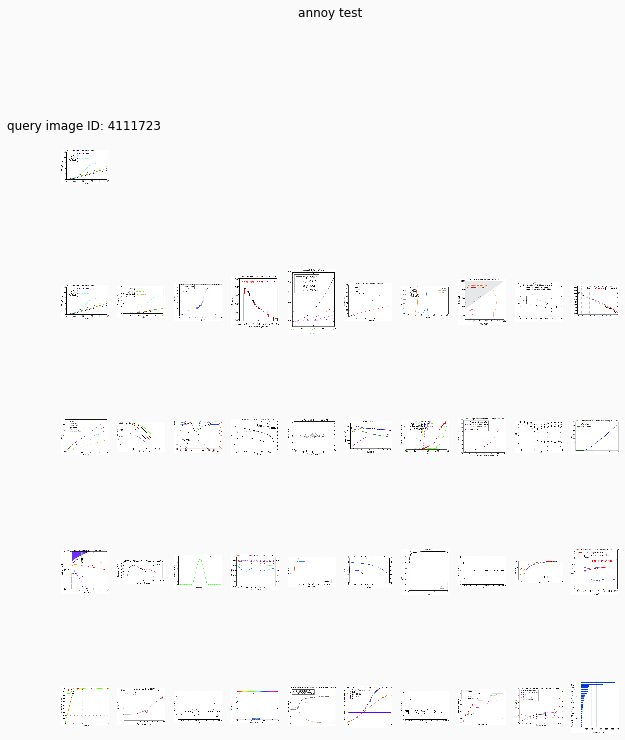

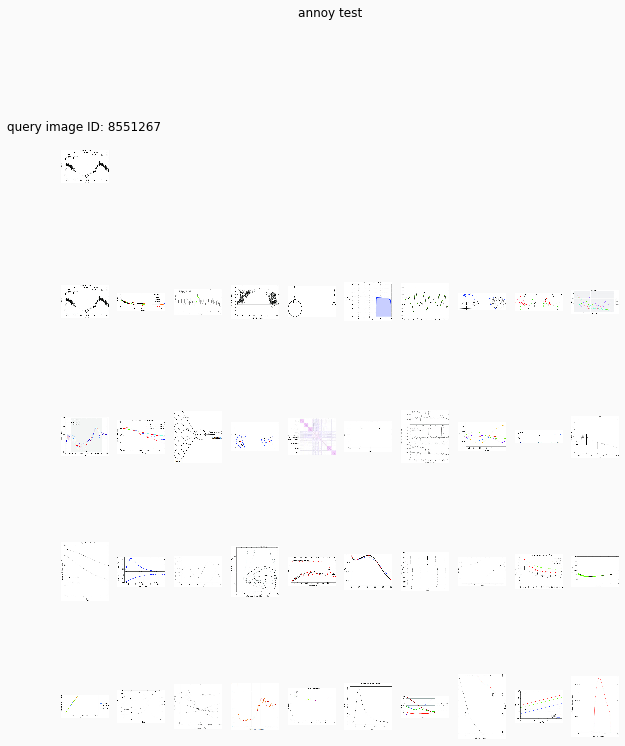

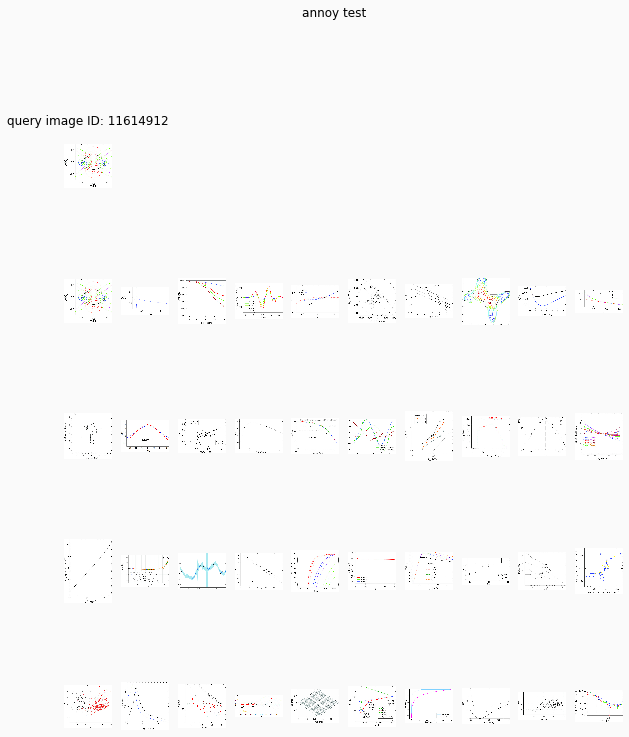

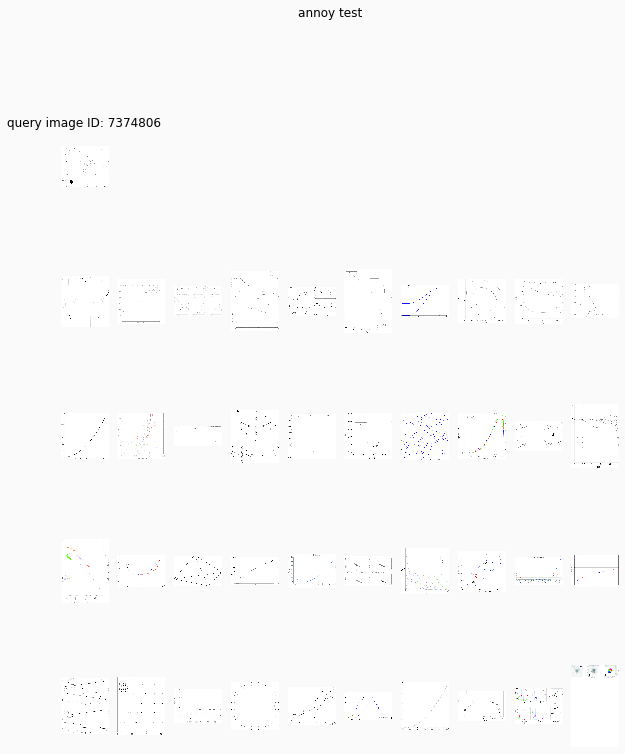

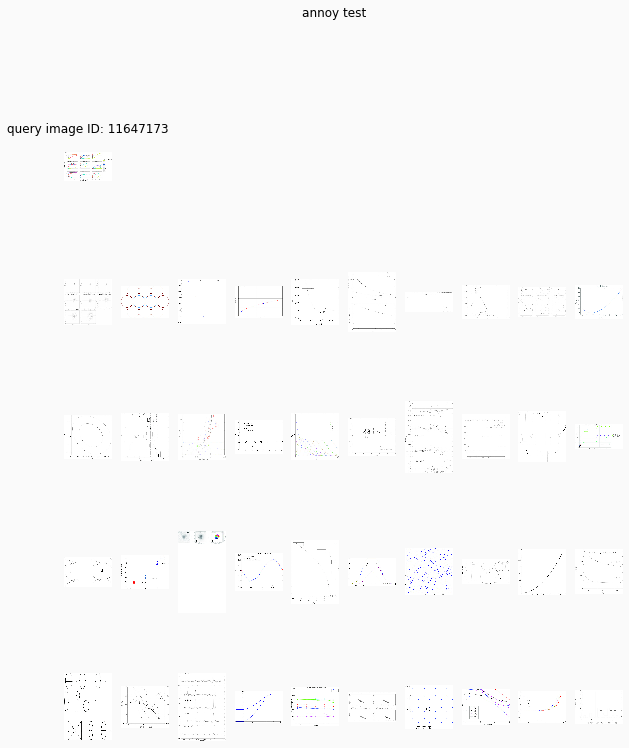

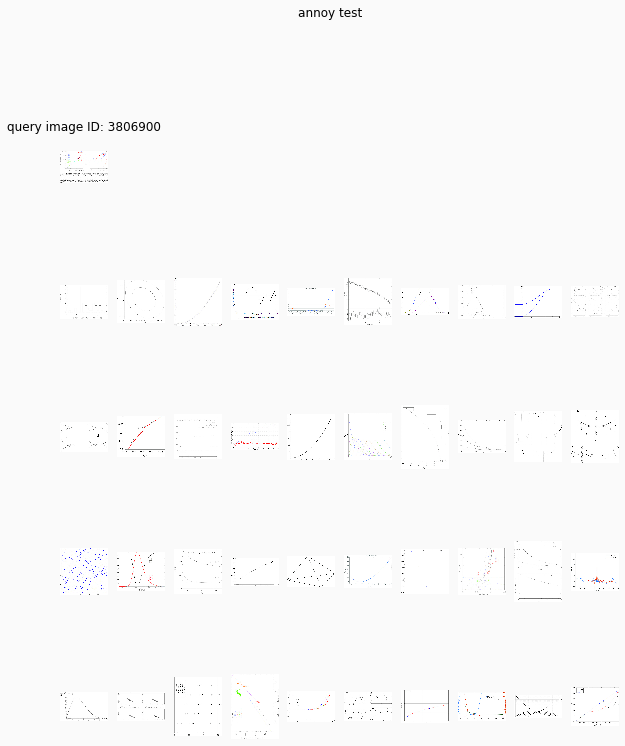

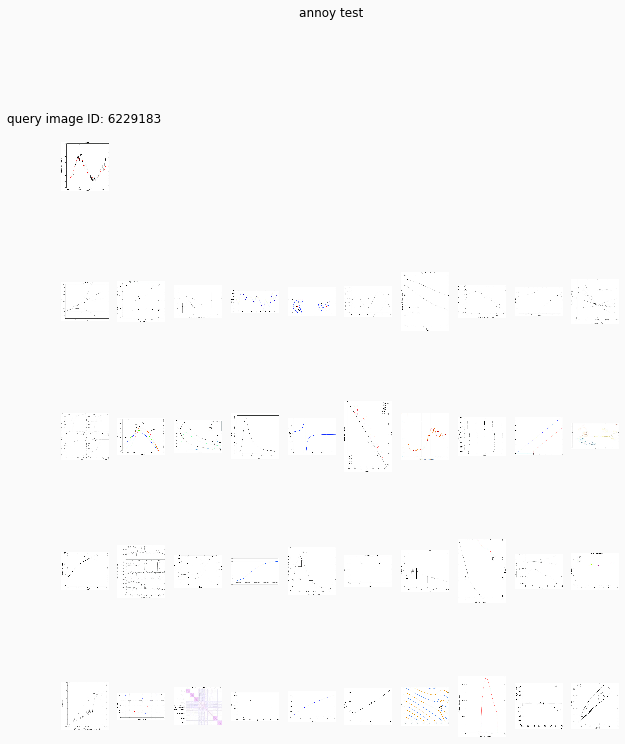

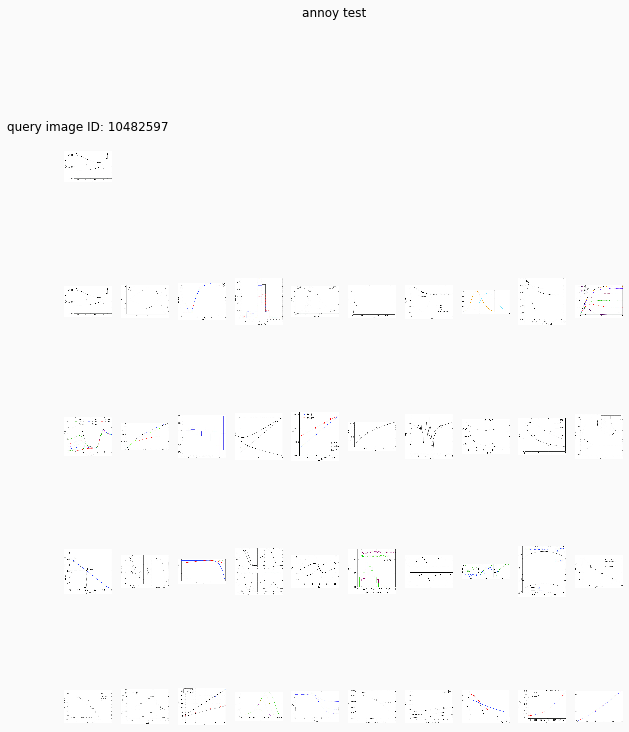

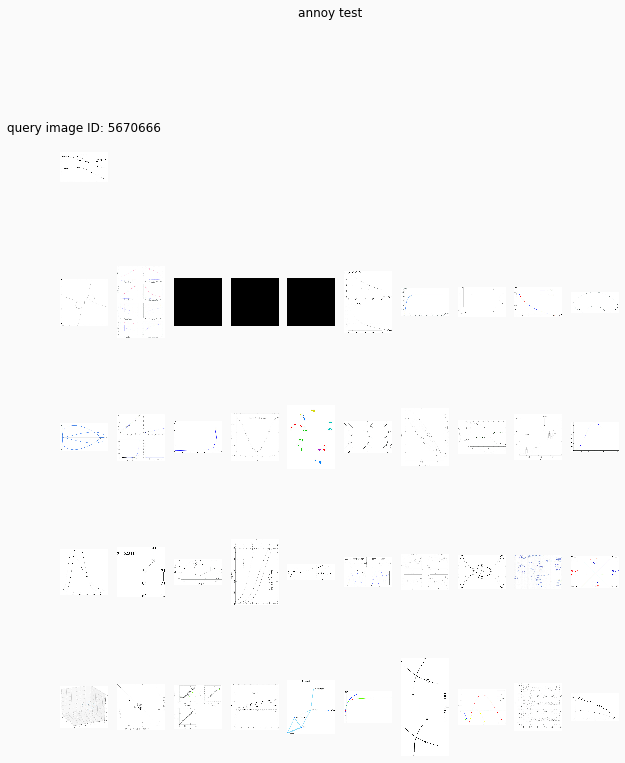

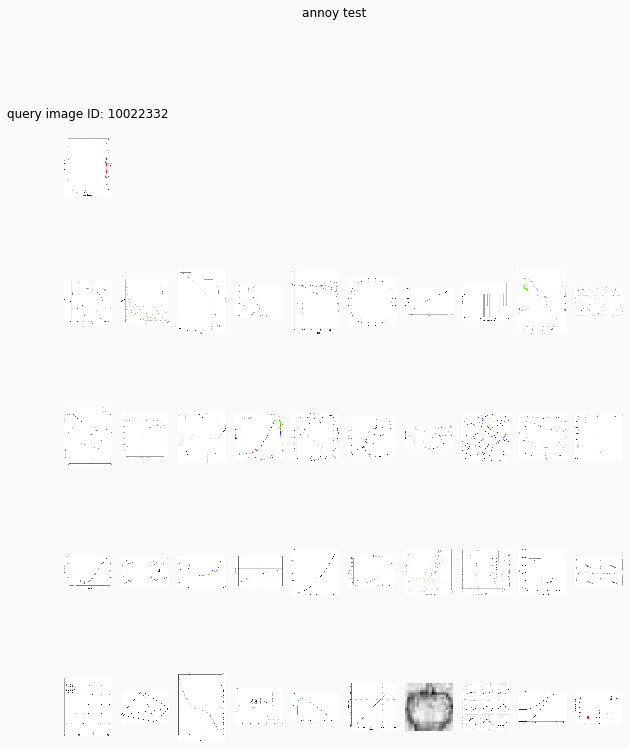

In [42]:
num_n = 50

for i in range(10):
    target_index = i
    print("index", target_index)
    indexes = t.get_nns_by_item(target_index, num_n)
    print(indexes)
    target_images = np.array(images)[np.array(indexes)]
    
    xdim = 10
    ydim = 5

    fig, ax = plt.subplots(ydim, xdim)
    fig.set_size_inches(10, 12)
    fig.patch.set_facecolor('0.98')
    #     print(filepaths[index].split(".")[0])
    title_string = "annoy test"
#     print(title_string)
    fig.suptitle(title_string, y=1.0)

    # display the query image
    query_image = mpimg.imread(images[target_index])
    ax[0, 0].imshow(query_image, cmap='Greys_r')
    ax[0, 0].set_title("query image ID: " + filepaths[target_index].split(".")[0], pad=20)

    for i in range(xdim):
        ax[0, i]. axis('off')

    for y in range(1, ydim):
        for x in range(xdim):
#             print(f"x: {x}, y: {y}")
            grid_index = (y * xdim) + x - xdim
#             print(f"grid_index: {grid_index}")
            current_image = mpimg.imread(target_images[grid_index])
            ax[y, x].imshow(current_image, cmap='Greys_r')
            ax[y, x].axis('off')

#     plt.tight_layout(pad=0.5)
    savename = f"{ann_filename.split('.')[0]}_{target_index}.jpg"
    # savename = f'{query_image_idx:04}' + "_" + filepaths[index].split(".")[0] + "_strip_1m.jpg"
    plt.savefig(savename, dpi=300, bbox_inches='tight')
    # print("completed", index)
    # print("time taken", "{:.4f}".format(time.time() - start))